# 0. Data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = sns.load_dataset(name="tips")


In [2]:
df.columns, df.shape, df.dropna().shape

(Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object'),
 (244, 7),
 (244, 7))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [4]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [5]:
for i in df.columns:
    if df[i].dtype.name == 'category':
        print(i)
        print(df[i].value_counts(), end ='\n\n')

sex
Male      157
Female     87
Name: sex, dtype: int64

smoker
No     151
Yes     93
Name: smoker, dtype: int64

day
Sat     87
Sun     76
Thur    62
Fri     19
Name: day, dtype: int64

time
Dinner    176
Lunch      68
Name: time, dtype: int64



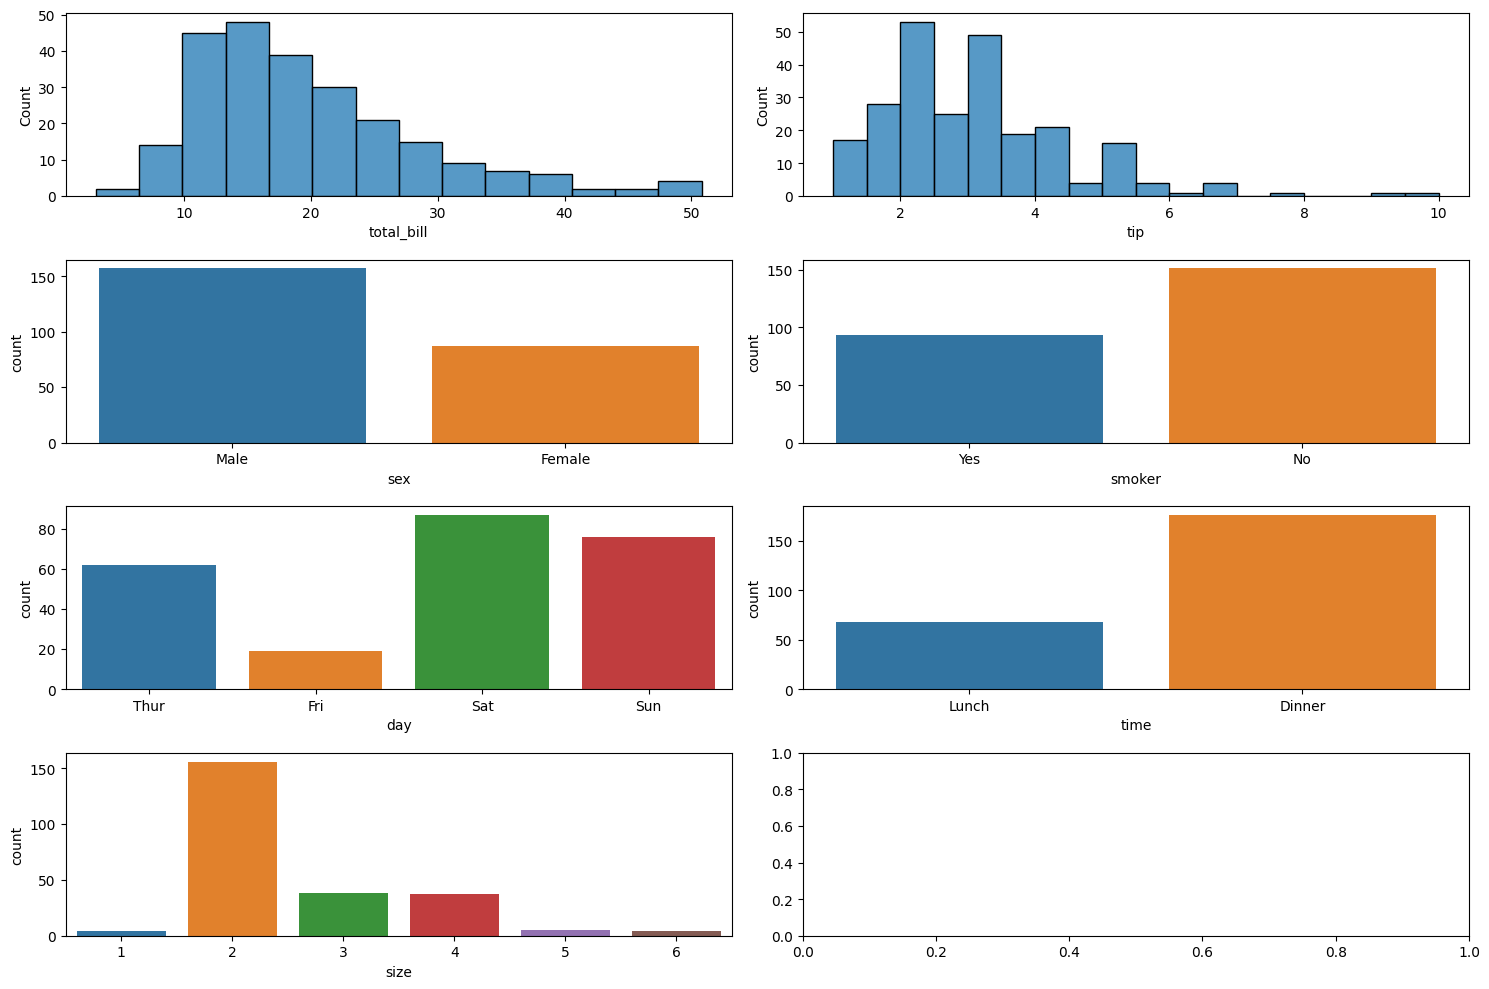

In [6]:
fig, ax = plt.subplots(4,2, figsize = (15,10))
ax = ax.flatten()

for i, col in enumerate(df.columns):

    if df[col].dtype.name == "float64":
        sns.histplot(df[col], ax = ax[i])
    else:
        sns.countplot(data = df, x=col, ax = ax[i])

fig.tight_layout()

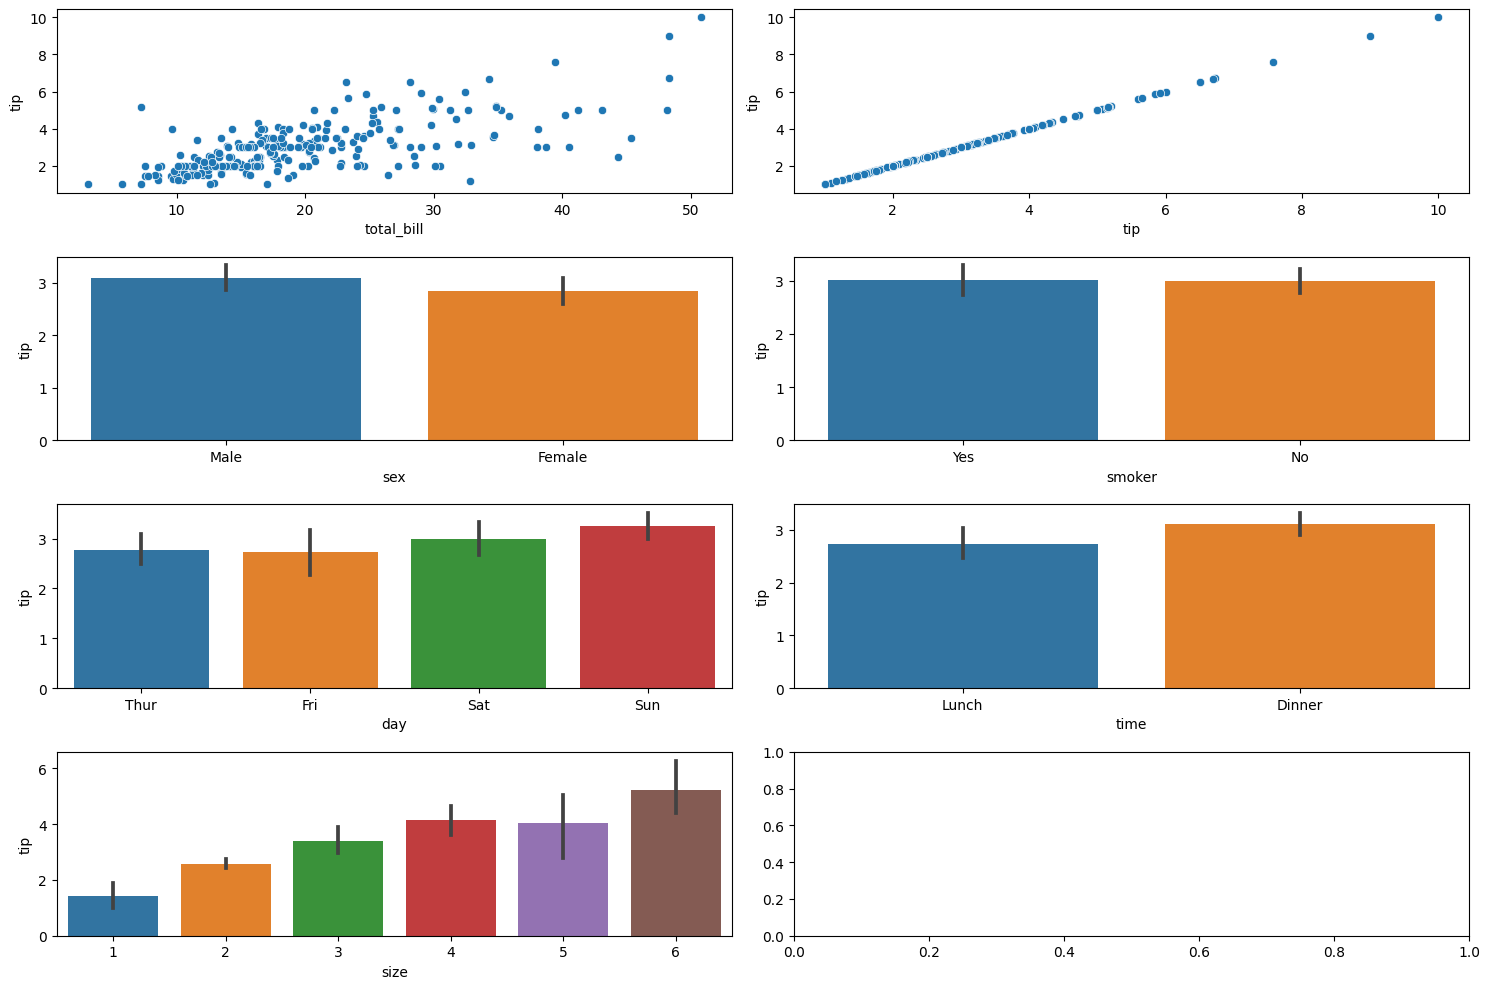

In [7]:
fig, ax = plt.subplots(4,2, figsize = (15,10))
ax = ax.flatten()

for i, col in enumerate(df.columns):

    if df[col].dtype.name == "float64":
        # sns.histplot(df[col], ax = ax[i])
        sns.scatterplot(data = df, x= col, y = "tip", ax = ax[i])

    else:
        sns.barplot(data = df, x=col, y = "tip", ax = ax[i])

fig.tight_layout()

# Preprocessing

In [8]:
from sklearn.model_selection import train_test_split

X = df.loc[:,["total_bill", "size"]]
y = df["tip"]
X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# z score standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_X_train = scaler.fit_transform(X_train)

scaled_X_train = (X_train - X_train.mean())/X_train.std()
scaled_X_test = (X_test - X_train.mean()) / X_train.std()

print(scaled_X_train.mean(), end = '\n\n')
print(scaled_X_test.mean(), end = '\n\n')
print(scaled_X_train.std(), end = '\n\n')
print(scaled_X_test.std(), end = '\n\n')

total_bill    6.791953e-17
size         -1.985340e-16
dtype: float64

total_bill   -0.191380
size         -0.044779
dtype: float64

total_bill    1.0
size          1.0
dtype: float64

total_bill    0.924957
size          1.066389
dtype: float64



# Polynomial feature engineering

In [67]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly_train = poly_features.fit_transform(scaled_X_train)
X_poly_test = poly_features.transform(scaled_X_test)
len(X_train.iloc[:,0] == X_poly_train[:,0])

170

In [68]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

rmse_train = []
rmse_test = []

for i in range(1,5):
    poly_features = PolynomialFeatures(degree=i, include_bias=False)

    X_poly_train = poly_features.fit_transform(scaled_X_train)
    X_poly_test = poly_features.transform(scaled_X_test)

    model = LinearRegression()

    model.fit(X_poly_train, y_train)

    y_hat_train = model.predict(X_poly_train)
    y_hat_test = model.predict(X_poly_test)

    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_hat_train)))
    rmse_test.append(np.sqrt(mean_squared_error(y_test, y_hat_test)))

(0.7, 2.75)

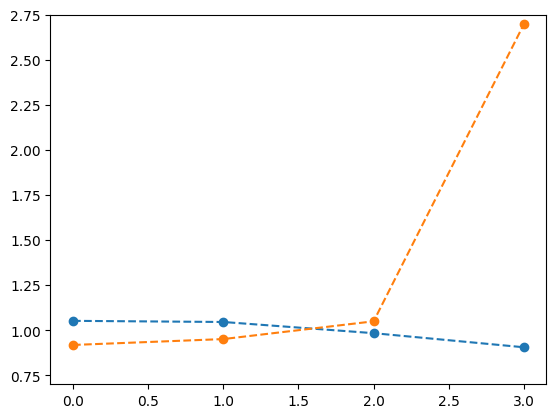

In [69]:
plt.plot(rmse_train, 'o--')
plt.plot(rmse_test, 'o--')
plt.ylim([0.7,2.75])

# Regularization methods

- Important to scale data with all regularization

## Ridge regression

In [78]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=4, include_bias=False)

# transforming after scaling - same result as transforming before
X_4poly_train = poly_features.fit_transform(scaled_X_train)
X_4poly_test = poly_features.transform(scaled_X_test)

model_ridge = RidgeCV(alphas = [0.01, 0.1, 0.5, 1.5, 5, 10])
model_ridge.fit(X_4poly_train, y_train)

print(model_ridge.alpha_)
print(model_ridge.coef_)
y_pred = model_ridge.predict(X_4poly_test)

print(f"{mean_squared_error(y_pred, y_test)=:.3f}")

5.0
[ 0.91469637  0.23893931 -0.67583593  0.20550801 -0.01369317 -0.26007685
  0.31867863 -0.03429744 -0.12484035  0.16000319 -0.18105113  0.24878399
 -0.12692847  0.05002613]
mean_squared_error(y_pred, y_test)=2.208


## Lasso regression

In [103]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(n_alphas=100, max_iter=10000)
model_lasso.fit(X_4poly_train, y_train)

y_pred = model_lasso.predict(X_4poly_test)
print(model_lasso.alpha_)
print(model_lasso.coef_)

mean_squared_error(y_pred, y_test)

0.20770232166587632
[ 0.23469707  0.         -0.         -0.          0.          0.08814685
  0.09735986  0.          0.03219702  0.          0.          0.
 -0.          0.        ]


1.3451967151343822

## Elasticnet regression

In [117]:
from sklearn.linear_model import ElasticNetCV

model_elastinet = ElasticNetCV(l1_ratio=[0.001, 0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 1], n_alphas=100, max_iter=10000)
model_elastinet.fit(X_4poly_train, y_train)

print(model_elastinet.alpha_)
# dir(model_elastinet)
print(model_elastinet.l1_ratio_)

y_pred = model_elastinet.predict(X_4poly_test)
np.sqrt(mean_squared_error(y_pred, y_test))

0.10711875299553128
0.9


1.1394492917805898